# **Image generation with Webtoon image using DDPM**

Diffusion probabilistic model(diffusion model) is a kind of latent variable model inspired from nonequilibrium thermodynamics. What I have dealt with is **DDPM(Denoising Diffusion Probablistic Model)** model, which is the original form of diffusion model.

You can see more about DDPM with related paper in the following link 📔 https://arxiv.org/abs/2006.11239

## **Introduction for DDPM**

There is two process in Diffusion model : **Forward process and Reverse process**.

In **forward process**, a random noise sampled from standard Gaussian distribution is added to the original image data for each timestep.

In **reverse process**, Diffusion model ascends the forward process by denoising the noised data and finds original data.

A key assumption is that **since the noise diffusion consists of small-magnitude Gaussian noise, the denoising can also be considered Gaussian**.

This assumption can make a parameterization of the neural network more simple.

![image.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/diffusion1.png)

**Forward process** from step t-1 to step t is denoted as $q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$, which follows Gaussian distribution.

To represent the mean and variance of the distribution, small constant coefficient factor $\beta$, which is called **schedule**, is applied.

$\beta_t$ should be designed to make $\bar{\alpha_T} \approx 0$ so that $q(x_T | x_0) \sim N(0, I)$.

By using the term $\beta$ and $\alpha$, we can easily derive $x_t$, the noised image at timestep = t.

![image.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/diffusion2.png)

**Reverse process** from step t to step t-1 is denoted as $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)$, and we can assume that it also follows Gaussian distribution since we set the value of $\beta$ small enough.

In training with given $x_0$, it is tractable with the form of $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t, \boldsymbol{x_0})$, and it is called **forward posterior**.

Using Bayse Rule, it can be change in terms of forward process distributions. Thus, we can derive the mean and variance of forward posterior in terms of $\bar{\alpha}$ and $\beta$.

![image.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/diffusion3.png)

Remember we have already get sampling image $x_t$ from $x_0$. Then, we can infer the value of $x_0$ from $x_t$. It makes the parameter of forward posterior distribution without the term of $x_0$.

In this process, the normal noise $\epsilon$ is replaced with $\widetilde{\epsilon_{t}}$. It represents the reverse denoising factor, **which we eventually trained by the DDPM model**.

![image.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/diffusion4.png)

Finally, we can sample the infered origianl image $x_0$ by progress forward posterior distribution $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t, \boldsymbol{\widetilde{\epsilon_{t}}})$ from step T to step 0.

![image.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/diffusion5.png)

Although there are other way to optimize the model by training other factors, the study in DDPM paper said that training nosie is the most optimal way to find desired output.

## **0. import modules**

In [1]:
%pip install einops
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.6 MB/s eta 0:0

In [2]:
# module for system
import os                                 # os : to manage directory and file
import gc                                 # gc : to use garbage collection
# module for calculation
import math                               # math functions
import numpy as np                        # numpy : numpy. You know that, right?
from tqdm.auto import tqdm                # tqdm : to show process bar while loading
import datasets                           # dataset : to load dataset from the external
# module for image display
from PIL import Image                     # Image : to read image file from outside
import matplotlib.pyplot as plt           # pyplot : to plot image
import matplotlib.animation as animation  # animation : to show gif
# module for Unet
from einops import rearrange              # rearrange : use for unet
from functools import partial             # partial : use for unet
from inspect import isfunction            # isfunction : use for unet
# module of pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import einsum
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, ToTensor, RandomHorizontalFlip
from torchvision.utils import save_image

Before start, determine which device we gonna use : GPU(cuda) or CPU(cpu)

In [3]:
# Device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("current device : {}".format(device))

current device : cuda


## **1. Dataset - StudyGroup in Naver Webtoon**

What I used for image dataset is character-face-image dataset that is extracted from Webtoon **'Studygroup'**.
📖 https://www.webtoons.com/en/action/study-group/list?title_no=3595

Since there is no Webtoon image dataset provided with one series, I crawled from the desired Webtoon series and made face-image dataset by running opencv face estimation model.

For charactor face recognition, **lbpcascade_animeface** was used as the pretrained model.

You can freely access with opensource repository 📔 https://github.com/nagadomi/lbpcascade_animeface

![image.png](https://github.com/Rayiz3/StudyGroupFace/blob/main/dataset.JPG?raw=true)

The estimation is targeted on the 200 episodes of the series, and 2,500 meaningful images are finally obtained. To ease of the task, the images are converted as gray-scale.
Following those process, character-face-image dataset **StudyGroup** is made with size of 32 * 32 sized 2,500 images.

The size of dataset is not large enough since the number of episodes revealed is not many to extract large amount of face data.

### 1.1. load dataset from github

First, we have to download the image datset from the github repository and unzip it.

In [8]:
!git clone https://github.com/Rayiz3/StudyGroupFace

Cloning into 'StudyGroupFace'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 30 (delta 3), reused 17 (delta 1), pack-reused 11
Unpacking objects: 100% (30/30), 133.76 MiB | 9.40 MiB/s, done.


In [9]:
!unzip StudyGroupFace/StudyGroup.zip

Archive:  StudyGroupFace/StudyGroup.zip
 extracting: StudyGroup/1_1_0.jpg    
 extracting: StudyGroup/1_10_0.jpg   
 extracting: StudyGroup/1_100_0.jpg  
 extracting: StudyGroup/1_107_0.jpg  
 extracting: StudyGroup/1_107_1.jpg  
 extracting: StudyGroup/1_109_0.jpg  
 extracting: StudyGroup/1_11_0.jpg   
 extracting: StudyGroup/1_110_0.jpg  
 extracting: StudyGroup/1_119_0.jpg  
 extracting: StudyGroup/1_18_0.jpg   
 extracting: StudyGroup/1_24_0.jpg   
 extracting: StudyGroup/1_28_0.jpg   
 extracting: StudyGroup/1_29_0.jpg   
 extracting: StudyGroup/1_31_0.jpg   
 extracting: StudyGroup/1_31_1.jpg   
 extracting: StudyGroup/1_32_0.jpg   
 extracting: StudyGroup/1_38_0.jpg   
 extracting: StudyGroup/1_4_0.jpg    
 extracting: StudyGroup/1_40_0.jpg   
 extracting: StudyGroup/1_42_0.jpg   
 extracting: StudyGroup/1_43_0.jpg   
 extracting: StudyGroup/1_47_0.jpg   
 extracting: StudyGroup/1_49_0.jpg   
 extracting: StudyGroup/1_50_0.jpg   
 extracting: StudyGroup/1_56_0.jpg   
 extractin

### 1.2. make dataset class 'Studygroup'

Base on the downloaded dataset, make a new Dataset class named **Studygroup**
As a torch.utils.data.Dataset class, it is required tree methods:

- __init__(self) : basic initializing fuction

- __getitem__(self, index) : return corresponding contents with given index in the dataset

- __len__(self) : return the length of the dataset

In [10]:
class Studygroup(Dataset):
    def __init__(self, root, transform=None):
        self.images = []
        name_list = os.listdir(root)

        for name in name_list:
            image = Image.open(root + name)
            if transform is not None:
                image = transform(image)
            self.images.append(image)

    def __getitem__(self, index):
        return self.images[index], index

    def __len__(self):
        return len(self.images)

Now, we are ready to use new dataset **Studygroup( )**.

## **2. Forward process - noise spreading**

### 2.1. image processing

This section is not a part of training, but to visualize the forward process.

The random image is selected, and be calculated with the form of **torch.tensor()**.

When visualize the image, it will be converted as the form of **PIL.Image**.

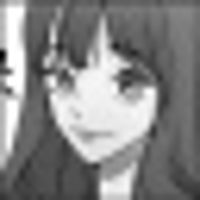

In [18]:
# make range [0,1] -> [-1,+1]
def input_T(input):
    return 2*input-1

# make range [-1,+1] -> [0,1]
def output_T(input):
    return (input+1)/2

# read image
image = Image.open("StudyGroup/1_4_0.jpg")

# image preprocessing
transform_for = Compose([ToTensor(),  # HWC -> CHW / [0-255] -> [0-1]
                         input_T])  # [0,1] -> [-1,+1]
transform_rev = Compose([output_T,  # [-1,+1] -> [0,1]
                         ToPILImage()])  # CHW -> HWC / [0-1] -> [0-255]

x_0 = transform_for(image).unsqueeze(0).to(device)  # B, C, H ,W
reversed_image = transform_rev(x_0.squeeze()).resize((200,200))
reversed_image.show()

### 2.2. statistic variables

Let the timesteps t = 2000, and the each terminal value ${\beta}_0$=0.0001, ${\beta}_T$=0.02.

The intermediate ${\beta}_t$ s are aligened evenly between 0.0001 ~ 0.02.

In addition, there are some statistics variables from $\beta$ value.

- alphas : $\alpha_{t} = 1 - \beta_{t}$

- alphas_bar = $\bar \alpha_{t}$

- alphas_bar_prev = $\bar \alpha_{t-1}$

- one_minus_alphas_bar =  $1 -\bar \alpha_{t}$

- sqrt_alphas_bar = $\sqrt{\bar \alpha_{t}}$

- sqrt_one_minus_alphas_bar = $\sqrt{1 - \bar \alpha_{t}}$

- sqrt_recip_alphas = $\sqrt{1 / \alpha_{t}}$

In [15]:
timesteps = 2000
beta_0 = 0.0001
beta_T = 0.02

# beta
betas = torch.linspace(beta_0, beta_T, timesteps)

# alpha
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, axis=0)
alphas_bar_prev = torch.concat([torch.tensor([1.]), alphas_bar[:-1]], 0)

# operation of alpha
one_minus_alphas_bar = 1 - alphas_bar
sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1 - alphas_bar)
sqrt_recip_alphas = torch.sqrt(1/alphas)

### 2.3. forward sampling fuction

They can be easliy get the image of timestep t by computing $q(x_t | x_0)$.

The role of each functions are described as comments above.

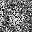

In [16]:
## extract ## ==================================================
# - extract corresponding elements
# - inputs are all batched form with batch_size = B
# [arguments]
# - a : target tensor
# - t : list of target index (B*1)
# - x_shape : shape of data x (B*...)
# ============================================================
def extract(a, t, x_shape):
    assert t.shape[0] == x_shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(t.shape[0], *([1] * (len(x_shape) - 1))).to(t.device)

## q_sample ## ===============================================
# - sample diffusion output of step t
# [arguments]
# - x_0 : first data
# - t : time step
# - noise : noise type
# ============================================================
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn(x_0.shape).to(device)

    term_x_0 = extract(sqrt_alphas_bar, t, x_0.shape)
    term_noise = extract(sqrt_one_minus_alphas_bar, t, x_0.shape)
    #print(term_x_0.device, x_0.device)
    return term_x_0 * x_0 + term_noise * noise

## make_noised_img ## ========================================
# - make PIL image from sampled x_t
# [arguments]
# - x_0 : first data
# - t : time step
# ============================================================
def make_noised_img(x_0, t):
    x_t = q_sample(x_0, t)
    noised_img = transform_rev(x_t.squeeze())
    return noised_img

t = torch.tensor([199]).to(device)
make_noised_img(x_0, t).show()

## plot_seq ## ===============================================
# - plot noising process in a row
# [arguments]
# - imgs : sequence of noised images
# - original : original image (=None)
# - row_title : title for each row (=None)
# ============================================================
def plot_seq(imgs, original=None, col_title=None):
    if not isinstance(imgs, list):
        imgs = [imgs] # make 2-dim array (1 * n)

    length = len(imgs)
    if original is not None:
        imgs = [original] + imgs
        length += 1

    fig, axs = plt.subplots(figsize=(200,200), nrows=1, ncols=length, squeeze=False)
    for idx, img in enumerate(imgs):
        ax = axs[0, idx]
        ax.imshow(img, cmap='gray')
        ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])  # remove labels

    # make title for each images
    original_idx = 0
    if original is not None:
        original_idx = 1
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(200)
    if col_title is not None:
        for idx in range(length-original_idx):
            axs[0, idx+1].set(title=col_title[idx])
            axs[0, idx+1].title.set_size(200)

    plt.tight_layout()
    plt.show()

By running the following code, you can find that the random noise is applied to the original image gradually as timestep t increase.

In [17]:
plot_seq([make_noised_img(x_0, torch.tensor([t]).to(device)) for t in [1, 50, 100, 150, 199]],
         original=image,
         col_title=["step : "+str(t) for t in [1, 50, 100, 150, 199]])

## **3. Unet sturcture**

In the middle of the DDPM model, Unet structure is applied.

Unet is a structure for image segmentation. It is named 'Unet' because of the encoding and decoding process that is similar is the letter 'U'.

Differ from auto encoder model, the state in the encoding process is refered in the decoding state.

The overall code implementation is refered from outside source.

![image.png](https://github.com/Rayiz3/StudyGroupFace/blob/main/unet.JPG?raw=true)

In [19]:
# Helper functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

In [20]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

# time embedding
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Takes a tensor of shape (batch_size, 1) as input
    (i.e. the noise levels of several noisy images in a batch),
    and turns this into a tensor of shape (batch_size, dim),
    with dim being the dimensionality of the position embeddings.
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [21]:
# layers for Unet structure
class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            condition = self.mlp(time_emb)
            # broadcast to each pixel the time embedding: [b,c,h,w] + [b,c,1,1]
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(
                t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(
                t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y",
                        h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [22]:
# main Unet architecture
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ConvNextBlock, mult=convnext_mult)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in,
                                    time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## **4. Reverse process - denoising**

Now, it's time to perform reverse process, the main part of DDPM.

### 4.1. loss function

As mentioned in the introduction, the denoising factor predicted from Unet structure will be trained.

Thus, our loss fuction should compare the predicted noise with a noise randomly sampled from N(0, I).

In [23]:
def p_losses(denoiser, x_0, t):

    noise = torch.randn(x_0.shape).to(device)  # noise ~ N(0, I)

    x_t = q_sample(x_0, t, noise=noise)  # x_t ~ q(x_t|x_0)

    predicted_noise = denoiser(x_t, t)  # noise_pred

    return F.smooth_l1_loss(noise, predicted_noise)

### 4.2. reverse sampling fuction

Using statistic variables declared before, we can implement sampling fuction of $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t, \boldsymbol{\widetilde{\epsilon_{t}}})$.

In [24]:
## p_sample ## =================================================
# - sample posterior ouput of step t
# [arguments]
# - model : learning model
# - x_t : data at step t
# - t : timestep (B*1)
# - index : timestep (scalar)
# ============================================================
@torch.no_grad()  # no backpropagation; reduce tasks (for testing)
def p_sample(model, x_t, t, index):
    sqrt_one_minus_alpha_bar = extract(sqrt_one_minus_alphas_bar, t, x_t.shape)
    sqrt_recip_alpha = extract(sqrt_recip_alphas, t, x_t.shape)
    beta = extract(betas, t, x_t.shape)

    mean_pred = sqrt_recip_alpha * (x_t - beta / sqrt_one_minus_alpha_bar * model(x_t, t))

    if index == 0:  # if step = 0, no noise
        return mean_pred
    else:  # else
        post_variance = (1 - alphas_bar_prev) / (1 - alphas_bar) * betas
        variance_pred = extract(post_variance, t, x_t.shape)
        noise = torch.randn(x_t.shape).to(device)
        return mean_pred + variance_pred * noise

## sample ## =================================================
# - sampling posterior from each timestep
# [arguments]
# - model : learning model
# - shape : (B, C, H, W)
# ============================================================
@torch.no_grad()
def sample(model, shape):
    device = next(model.parameters()).device

    # initial noise
    img = torch.rand(shape, device=device)
    imgs = []

    loading = tqdm(reversed(range(0, timesteps)),
                   desc='sampling loop time step',  # text in front of loading
                   total=timesteps)  # number of iteration
    for i in loading:
        img = p_sample(model, img, torch.full((shape[0],), i,
                                              device=device,
                                              dtype=torch.long), i)
        #ToPILImage()(img[0]).show()
        imgs.append(img.cpu().numpy())
    return imgs

## **5. Training**

### 5.1. tutorial - mnist

I will first show the example of famous MNIST dataset to show the training process.

First, load dataset from the external and set the hyperparameters.

In [26]:
# remove remain GPU memory
gc.collect()
torch.cuda.empty_cache()

# load dataset
dataset = datasets.load_dataset("mnist")

# hyper parameters
image_size = 28
channels = 1

batch_size = 128
lr = 1e-3
max_epoch = 10

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist downloaded and prepared to /root/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Next is for neural network framework.

Apply the preprocessing transforms and extract image data from the dataset sturcture.

Then, declare a Unet model and optimizer Adam.

In [27]:
transform = Compose([ToTensor(),
                     input_T])

def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

dataset = dataset.with_transform(transforms)

dataloader = DataLoader(dataset=dataset["train"], batch_size=batch_size, shuffle=True)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [28]:
for epoch in range(max_epoch):
    print("epoch: {}".format(epoch+1))
    # dataset iteration
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # t ~ U(1, T)
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t)

      loss.backward()
      optimizer.step()

      if step % 100 == 0:
          print("Epoch [ {}/{} ]  Step [ {}/{} ]  p_loss : {:.5f}"
                .format(epoch+1, max_epoch, step+1, len(dataloader), loss.item()))

epoch: 1
Epoch [ 1/10 ]  Step [ 1/469 ]  p_loss : 0.48553
Epoch [ 1/10 ]  Step [ 101/469 ]  p_loss : 0.08444
Epoch [ 1/10 ]  Step [ 201/469 ]  p_loss : 0.03425
Epoch [ 1/10 ]  Step [ 301/469 ]  p_loss : 0.02383
Epoch [ 1/10 ]  Step [ 401/469 ]  p_loss : 0.02333
epoch: 2
Epoch [ 2/10 ]  Step [ 1/469 ]  p_loss : 0.01188
Epoch [ 2/10 ]  Step [ 101/469 ]  p_loss : 0.01715
Epoch [ 2/10 ]  Step [ 201/469 ]  p_loss : 0.01322
Epoch [ 2/10 ]  Step [ 301/469 ]  p_loss : 0.01303
Epoch [ 2/10 ]  Step [ 401/469 ]  p_loss : 0.01174
epoch: 3
Epoch [ 3/10 ]  Step [ 1/469 ]  p_loss : 0.01541
Epoch [ 3/10 ]  Step [ 101/469 ]  p_loss : 0.01573
Epoch [ 3/10 ]  Step [ 201/469 ]  p_loss : 0.01095
Epoch [ 3/10 ]  Step [ 301/469 ]  p_loss : 0.01129
Epoch [ 3/10 ]  Step [ 401/469 ]  p_loss : 0.01191
epoch: 4
Epoch [ 4/10 ]  Step [ 1/469 ]  p_loss : 0.01099
Epoch [ 4/10 ]  Step [ 101/469 ]  p_loss : 0.01379
Epoch [ 4/10 ]  Step [ 201/469 ]  p_loss : 0.01397
Epoch [ 4/10 ]  Step [ 301/469 ]  p_loss : 0.01168
Epo

### 6.2. real training - Studygroup

The following section is for training model for Studygroup dataset.

In [37]:
# remove remain GPU memory
gc.collect()
torch.cuda.empty_cache()

# hyper parameters
image_size = 32
channels = 1

batch_size = 50
lr = 1e-3
max_epoch = 500

dataset = Studygroup("StudyGroup/",
                     transform=Compose([RandomHorizontalFlip(), # filp image conditionally
                                       ToTensor(),
                                       input_T]))
dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True)
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
).to(device)

optimizer = Adam(model.parameters(), lr=lr)

for epoch in range(max_epoch):
    print("epoch: {}".format(epoch+1))
    # dataset iteration
    for step, (img_batch, label) in enumerate(dataloader):
        optimizer.zero_grad()

        img_batch = img_batch.to(device)

        # t ~ U(1, T)
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, img_batch, t)

        loss.backward()
        optimizer.step()

        if step % 25 == 0:
            print("Epoch [ {}/{} ]  Step [ {}/{} ]  p_loss : {:.5f}"
                  .format(epoch+1, max_epoch, step+1, len(dataloader), loss.item()))

epoch: 1
Epoch [ 1/500 ]  Step [ 1/50 ]  p_loss : 0.47538
Epoch [ 1/500 ]  Step [ 26/50 ]  p_loss : 0.35963
epoch: 2
Epoch [ 2/500 ]  Step [ 1/50 ]  p_loss : 0.11069
Epoch [ 2/500 ]  Step [ 26/50 ]  p_loss : 0.06703
epoch: 3
Epoch [ 3/500 ]  Step [ 1/50 ]  p_loss : 0.06417
Epoch [ 3/500 ]  Step [ 26/50 ]  p_loss : 0.04721
epoch: 4
Epoch [ 4/500 ]  Step [ 1/50 ]  p_loss : 0.04193
Epoch [ 4/500 ]  Step [ 26/50 ]  p_loss : 0.03390
epoch: 5
Epoch [ 5/500 ]  Step [ 1/50 ]  p_loss : 0.04333
Epoch [ 5/500 ]  Step [ 26/50 ]  p_loss : 0.03393
epoch: 6
Epoch [ 6/500 ]  Step [ 1/50 ]  p_loss : 0.04311
Epoch [ 6/500 ]  Step [ 26/50 ]  p_loss : 0.03732
epoch: 7
Epoch [ 7/500 ]  Step [ 1/50 ]  p_loss : 0.02106
Epoch [ 7/500 ]  Step [ 26/50 ]  p_loss : 0.02942
epoch: 8
Epoch [ 8/500 ]  Step [ 1/50 ]  p_loss : 0.03257
Epoch [ 8/500 ]  Step [ 26/50 ]  p_loss : 0.03934
epoch: 9
Epoch [ 9/500 ]  Step [ 1/50 ]  p_loss : 0.01644
Epoch [ 9/500 ]  Step [ 26/50 ]  p_loss : 0.03114
epoch: 10
Epoch [ 10/500 ]  

## **6. Testing(Sampling)**

Let's sample each data for each timesteps.

### 6.1. sampling & extract gif file

In [38]:
# sampling images
samples = sample(model, (batch_size, channels, image_size, image_size))  # timestep * batch * 3 * 128 * 128

sampling loop time step:   0%|          | 0/2000 [00:00<?, ?it/s]

The following code will show the last step($x_0$) of certain index of sampled image with gray scale.

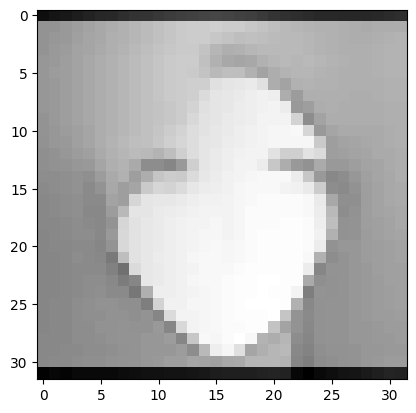

In [41]:
index = 40
im = samples[-1][index]
im = im.reshape(image_size, image_size, channels)
im = (output_T(im) * 255).astype(np.uint8)
plt.imshow(im, cmap='gray')

You can also see the process of denoising as gif animation file.

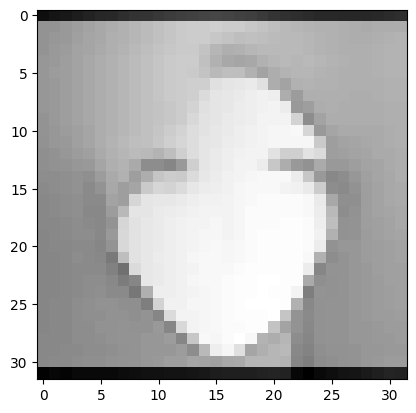

In [42]:
# show the process as gif image
fig = plt.figure()
ims = []
for i in range(timesteps):
    im = samples[i][index]
    im = im.reshape(image_size, image_size, channels)
    im = (output_T(im) * 255).astype(np.uint8)
    im = plt.imshow(im, animated=True, cmap='gray')
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion_process.gif')
plt.show()


### 6.2. result of Studygroup

I have captured the result of Studygroup dataset case, and there is some gif files.

![output1.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/output1.png)
![output2.png](https://raw.githubusercontent.com/Rayiz3/StudyGroupFace/main/output2.png)
![output3.png](https://github.com/Rayiz3/StudyGroupFace/blob/main/output3.png?raw=true)

![outputgif1.gif](https://github.com/Rayiz3/StudyGroupFace/blob/main/outputgif1.gif?raw=true)
![outputgif2.gif](https://github.com/Rayiz3/StudyGroupFace/blob/main/outputgif2.gif?raw=true)
![outputgif3.gif](https://github.com/Rayiz3/StudyGroupFace/blob/main/outputgif3.gif?raw=true)